<a href="https://colab.research.google.com/github/alimohdapg/fyp_Model_Comparsion/blob/main/Model_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
!pip3 install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
!pip3 install transformers
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, logging, set_seed
import numpy as np
!pip3 install datasets
import datasets

In [ ]:
def preprocess(comments):
    new_comments = []
    for comment in comments:
        new_text = []
        for t in comment.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        new_comments.append(" ".join(new_text))
    return new_comments

In [ ]:
file_path = 'Google Drive/My Drive/University/Year 3/FYP/Comments.csv'
df = pd.read_csv(file_path)
comments = preprocess(df['Comment'].values.tolist())
sentiments = df['Comment Sentiment'].values.tolist()
labels = ['Pos', 'Neu', 'Neg']
logging.set_verbosity_error()

In [ ]:
def compute_metrics(sentiments, preds):
    metrics = []
    metrics.append(accuracy_score(sentiments, preds))
    metrics.append(confusion_matrix(sentiments, preds, labels=labels))
    for func in (f1_score, precision_score, recall_score):
        metrics.append(func(sentiments, preds, average='macro'))
    return metrics

In [ ]:
def display_metrics(metrics):
    print(f'Acccuracy: {metrics[0]}')
    print(f'F1 Score: {metrics[2]}')
    print(f'Precision Score: {metrics[3]}')
    print(f'Recall Score: {metrics[4]}\n')
    ConfusionMatrixDisplay(confusion_matrix=metrics[1], display_labels=labels).plot()

# VADER

In [ ]:
vader = SentimentIntensityAnalyzer()

In [ ]:
def vader_assign_labels(preds):
    for i in range(len(preds)):
        if preds[i]['compound'] >= 0.05:
            preds[i] = 'Pos'
        elif preds[i]['compound'] <= -0.05:
            preds[i] = 'Neg'
        else:
            preds[i] = 'Neu'
    return preds

In [ ]:
vader_preds = []
for comment in comments:
    vader_preds.append(vader.polarity_scores(comment))
vader_preds = vader_assign_labels(vader_preds)

Acccuracy: 0.6553308823529411
F1 Score: 0.6276156643532453
Precision Score: 0.6529302386305277
Recall Score: 0.6201879392721971



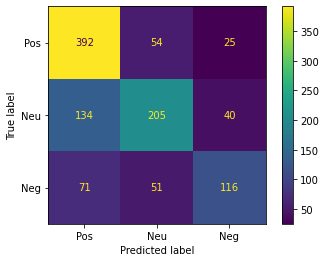

In [ ]:
vader_metrics = compute_metrics(sentiments, vader_preds)
display_metrics(vader_metrics)

# Twitter-roBERTa-base 

In [ ]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
def troberta_match_labels(preds):
    for i in range(len(preds)):
        if preds[i]['label'] == 'positive':
            preds[i] = 'Pos'
        elif preds[i]['label'] == 'negative':
            preds[i] = 'Neg'
        else:
            preds[i] = 'Neu'
    return preds

### Twitter-roBERTa-base (Unfine-tuned)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
troberta = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Acccuracy: 0.7693014705882353
F1 Score: 0.7578261474254168
Precision Score: 0.7575271564564231
Recall Score: 0.7582596993556004



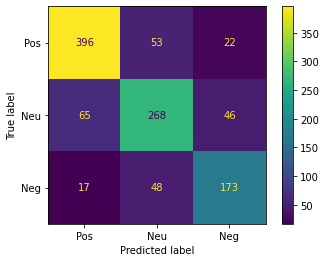

In [ ]:
troberta_preds = troberta_match_labels(troberta(comments))
troberta_metrics = compute_metrics(sentiments, troberta_preds)
display_metrics(troberta_metrics)

### Twitter-roBERTa-base (Fine-tuned)



In [ ]:
seed = 12345
set_seed(seed)

In [ ]:
def sentiments_to_id(sentiments):
    id_sentiments = []
    for sentiment in sentiments:
        if sentiment == 'Neg':
            id_sentiments.append(0)
        elif sentiment == 'Neu':
            id_sentiments.append(1)
        else:
            id_sentiments.append(2)
    return id_sentiments

In [ ]:
temp = list(zip(comments, sentiments))
rng = np.random.default_rng(seed)
rng.shuffle(temp)
shuffled_comments, shuffled_sentiments = zip(*temp)
shuffled_id_sentiments = sentiments_to_id(shuffled_sentiments)

In [ ]:
# training set: 1088 * 0.7 = 761.6 (761)
# validation set: 1088 * 0.2 = 217.6 (218), 761 + 218 = 979
# testing set: 1088 * 0.1 = 108.8 (109), 979 + 109 = 1088
folds = []
kf = KFold(n_splits=5)
for fold_i, (train_index, val_index) in enumerate(kf.split(comments[:979])):
    curr_fold = {split: {'text': [], 'label': []} for split in ['train', 'val']}
    for i in train_index:
        curr_fold['train']['text'].append(shuffled_comments[i])
        curr_fold['train']['label'].append(shuffled_id_sentiments[i])
    for i in val_index:
        curr_fold['val']['text'].append(shuffled_comments[i])
        curr_fold['val']['label'].append(shuffled_id_sentiments[i])
    folds.append(curr_fold)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',                   # output directory
    seed=seed                                 # seed for consistent result
)
num_labels = 3
finetuned_model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=num_labels)
for i in range(5):
    train_dataset = folds[i]['train']
    val_dataset = folds[i]['val']
    train_dataset = datasets.Dataset.from_dict(train_dataset)
    val_dataset = datasets.Dataset.from_dict(val_dataset)
    train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True), batched=True)
    val_dataset = val_dataset.map(lambda e: tokenizer(e['text'], truncation=True), batched=True)
    trainer = Trainer(
        model=finetuned_model,                    # the instantiated 🤗 Transformers model to be trained
        tokenizer=tokenizer,                      # tokenizer to be used to pad the inputs 
        args=training_args,                       # training arguments, defined above
        train_dataset=train_dataset,              # training dataset
        eval_dataset=val_dataset,                 # evaluation dataset
    )
    trainer.train()
finetuned_troberta = pipeline("sentiment-analysis", model=finetuned_model, tokenizer=tokenizer)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 783
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 294
  Number of trainable parameters = 124647939
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the 

{'train_runtime': 246.0372, 'train_samples_per_second': 9.547, 'train_steps_per_second': 1.195, 'train_loss': 0.40026307916965614, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 783
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 294
  Number of trainable parameters = 124647939


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 230.6495, 'train_samples_per_second': 10.184, 'train_steps_per_second': 1.275, 'train_loss': 0.26954622333552564, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 783
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 294
  Number of trainable parameters = 124647939


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 237.6514, 'train_samples_per_second': 9.884, 'train_steps_per_second': 1.237, 'train_loss': 0.1594655432668673, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 783
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 294
  Number of trainable parameters = 124647939


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 226.5667, 'train_samples_per_second': 10.368, 'train_steps_per_second': 1.298, 'train_loss': 0.10601951962425596, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 784
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 294
  Number of trainable parameters = 124647939


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 240.2069, 'train_samples_per_second': 9.792, 'train_steps_per_second': 1.224, 'train_loss': 0.0908616254118835, 'epoch': 3.0}


Acccuracy: 0.8440366972477065
F1 Score: 0.8247773089545242
Precision Score: 0.8209022556390977
Recall Score: 0.8307703055548279



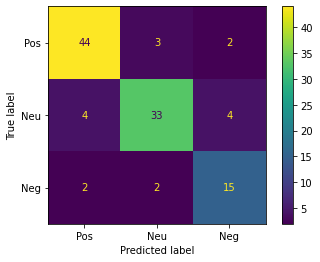

In [ ]:
finetuned_troberta_preds = troberta_match_labels(finetuned_troberta(list(shuffled_comments[979:])))
finetuned_troberta_metrics = compute_metrics(shuffled_sentiments[979:], finetuned_troberta_preds)
display_metrics(finetuned_troberta_metrics)

Acccuracy: 0.8073394495412844
F1 Score: 0.7911965811965812
Precision Score: 0.7869381987029046
Recall Score: 0.7982499803515758



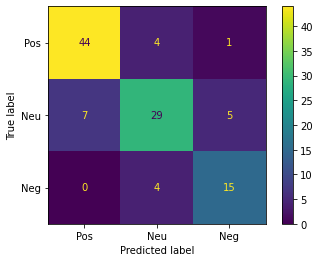

In [ ]:
troberta_preds = troberta_match_labels(troberta(list(shuffled_comments[979:])))
troberta_metrics = compute_metrics(shuffled_sentiments[979:], troberta_preds)
display_metrics(troberta_metrics)

#### Saving Twitter-roBERTa-base (Fine-tuned)

In [ ]:
finetuned_model.save_pretrained('Google Drive/My Drive/University/Year 3/FYP/Model')

Configuration saved in Google Drive/My Drive/University/Year 3/FYP/Model/config.json
Model weights saved in Google Drive/My Drive/University/Year 3/FYP/Model/pytorch_model.bin
